# The Merton model
Accounting data is from Compustat and return data from CRSP, risk free from Kenneth French's data library, the data is a (very) small subset of the data used in Forssbaeck and Vilhelmsson (2017)


In [1]:
#Import packages
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.optimize import minimize



In [2]:
# Read CSV files
accounting_data = pd.read_csv('AccountingData.csv')
price_data = pd.read_csv('ReturnData.csv')
risk_free = pd.read_csv('Riskfree.csv')
# data is of different frequency so I keep it in seperate dataframes
print(accounting_data)




    CUSIP     LCT     DLTT    CSHO  fyear
0  307108  34.337  140.335  22.814   2015


CUSIP is a firm identifier from Compustat, LCT is total current liabilities, DLTT is long term debt, CSHO is number of shares, fyear is fiscal year. All amounts in MUSD. The firm is AAC Holdings.


In [3]:
print(price_data)


     Cusip      Date  Prices
0    30710  20150102  30.210
1    30710  20150105  29.730
2    30710  20150106  29.380
3    30710  20150107  28.640
4    30710  20150108  29.370
..     ...       ...     ...
247  30710  20151224  28.845
248  30710  20151228  28.110
249  30710  20151229  27.900
250  30710  20151230  27.825
251  30710  20151231  28.590

[252 rows x 3 columns]


ReturnData contains daily stock Prices (yes, bad file name)

In [4]:
print(risk_free)

      Date  Riskfree
0   201501      0.00
1   201502      0.00
2   201503      0.00
3   201504      0.00
4   201505      0.00
5   201506      0.00
6   201507      0.00
7   201508      0.00
8   201509      0.00
9   201510      0.00
10  201511      0.00
11  201512      0.01


Monthly 1-month T-bill expressed as annual interest rates (the zeros are correct and are not missing values).

We estimate the Merton model with the function myMerton we do this so we can see in detail what we are doing, there is also package called [Merton-model](https://pypi.org/project/merton-model/) 

mymerton(sige,E,d,rf,t,x0). The first input, sige, is the equity standard deviation expressed annually, E is the current market value of equity, K is the face value of debt, rf is the risk free rate, t is the time horizon in years, x0 is a 1x2 vector of starting values for asset volatlity and asset value. The function returns asset volatlity and total assets (as well as the function value and an exit flag for why the optimization stopped).

In [5]:
def my_merton(x,sige,E,d,rf,t):
     d1 = (np.log(x[1]/d)+(rf+0.5*x[0]**2)*t)/(x[0]*np.sqrt(t))
     d2 = d1-x[0]*np.sqrt(t)
     f1 = x[1]*norm.cdf(d1)-np.exp(-rf*t)*d*norm.cdf(d2)-E # This is the equation on slide 21 Video L13 
     f2 = (x[1]/E)*norm.cdf(d1)*x[0]-sige # This is the equation on slide 22 Video L13 
     return np.sqrt(f1**2+f2**2) # Minimize f over x(1) and x(2) solves for Equity vol and Asset value

equityReturns = np.log(price_data.Prices/price_data.Prices.shift(1))
equityReturns = equityReturns[1:-1] # Removing the nan created by calculating returns
sige = stats.tstd(equityReturns)*np.sqrt(250) # Standard deviation of equity (returns) scaled to yearly
K = accounting_data.LCT+0.1*accounting_data.DLTT # We use 10% of long term debt which was found best in Afik et al. (2016)
E = accounting_data.CSHO*price_data.Prices.iloc[-1] # Equity in MUSD as Number of shares * last share price
rf = np.mean(risk_free.Riskfree) # Risk free rate as average of monthly rates
t = 1 # We want PD in 1 year
x0=(sige,K[0]+E[0]) # Initial quess for asset volatility and asset value,
                    # easier and faster for numerical optimization if guess is good
x0bad = (sige,400)


res = minimize(my_merton, x0bad, method='BFGS',
               args=(sige,E[0],K[0],rf,t), options={'disp': True})
print("Asset volatility is {:.3f} and asset value is {:.2f}".format(res.x[0],res.x[1]))

         Current function value: 0.000000
         Iterations: 49
         Function evaluations: 472
         Gradient evaluations: 154
Asset volatility is 0.599 and asset value is 700.58


In [6]:
DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t)) # DD slide 9 VL 13
PD = float(norm.cdf(-DD))
print("Probability of default within one year is {:.5f} %".format(PD*100))

Probability of default within one year is 0.00155 %


In [7]:
# Comparing with the build-in mertonmodel function in Matlab gives 0.0015% so they got it right again at Mathworks!


## Evaluating PD forecasts using ROC/CAP curves
Evaluation is based on all US  listed companies from 1980-2019. Details of coding is not part of exam (that is you do not need to be able to construct a ROC curve from scratch) but you need to understand how to read a ROC curve and what the accuracy ratio is.
The data contains: Column 1) Gvkey from Compustat  Columns 2-3) 164,803 DD estimates for 2 models implementations of Merton,  Column 4) financial year  Column 5) Year used for estimating DD Column 6) Year delisted independent of delisting reason (NaN if not delisted)  Column 7) Defaulted, equal to 1 if defaulted  delisting is considered default if Compustat delisting code is chapter 7 or 11 or if the company has filed an 8-K with EDGAR which mention delist* AND (Chapter 7 OR Chapter 11)
The only difference in implementation is the drift term, model 1 has the riskfree rate, model two has last year emprical equity return.

In [8]:
dd_data = pd.read_csv('dd_data.zip') # Pandas can read zipped files
print(dd_data)

         gvkey  TB_merton_rf  TB_merton_my  fyear  year_DD  year_delisted  \
0         1001      6.285012      5.195522   1985     1983         1986.0   
1         1003      5.566477      4.333835   1986     1984         1992.0   
2         1003      4.833207      4.059220   1987     1985         1992.0   
3         1003      9.838238      8.500119   1988     1986         1992.0   
4         1003      3.970668      3.495942   1989     1987         1992.0   
...        ...           ...           ...    ...      ...            ...   
164798  318005      4.358595      4.454846   2019     2017            NaN   
164799  318728     34.386008     34.123249   2019     2017            NaN   
164800  319507      2.559973      2.543854   2019     2017            NaN   
164801  335466      3.121704      3.090731   2018     2016            NaN   
164802  335466      1.046745      0.999023   2019     2017            NaN   

        defaulted  
0               0  
1               0  
2              

In [9]:
start_year = 1980
end_year = 2019
data = dd_data


In [10]:
defaults_by_year = data.groupby(['year_delisted'])['defaulted'].sum()
print(defaults_by_year)

year_delisted
1982.0     3
1983.0     5
1984.0    10
1985.0    21
1986.0    40
1987.0    20
1988.0    34
1989.0    29
1990.0    12
1991.0    36
1992.0    42
1993.0    67
1994.0    40
1995.0    33
1996.0    26
1997.0    16
1998.0    26
1999.0    18
2000.0    32
2001.0    22
2002.0    16
2003.0    23
2004.0    34
2005.0    18
2006.0    14
2007.0    11
2008.0    11
2009.0    29
2010.0    25
2011.0    28
2012.0    31
2013.0    27
2014.0    17
2015.0    20
2016.0    20
2017.0    14
2018.0    15
2019.0    26
2020.0    10
Name: defaulted, dtype: int64


### Power (ROC) curves



In [11]:
# Function to compute power (ROC) curve, data is Pandas df, idx is column with DD
# Note the function is not general but specific to the stucture of our dataset
def roc_curve(start_year,end_year,data,idx,sorton):
    i = 0
    n_dd_year = []
    power_curve = np.zeros((end_year-start_year+1,5000))
    power_curve[:] = np.nan
    for j_year in range(start_year+2,end_year+1):
        dds_year = data[data.year_delisted==j_year]
        dds_year_series = dds_year.iloc[:,[idx,6]]
        dd_sorted = dds_year_series.sort_values(by=sorton)
        n_dd_year.append(len(dds_year)) 
        # Power curve is fraction of defaulted over total defaults, computed by adding companies sorted on DD (or PD)
        power_curve[i,0:n_dd_year[i]] = np.nancumsum(dd_sorted.defaulted.values)/np.nansum(dd_sorted.defaulted.values)
        i += 1
    return power_curve,n_dd_year

power_curve_rf,n_dd_year = roc_curve(start_year,end_year,data,1,'TB_merton_rf')
power_curve_my,n_dd_year = roc_curve(start_year,end_year,data,2,'TB_merton_my')


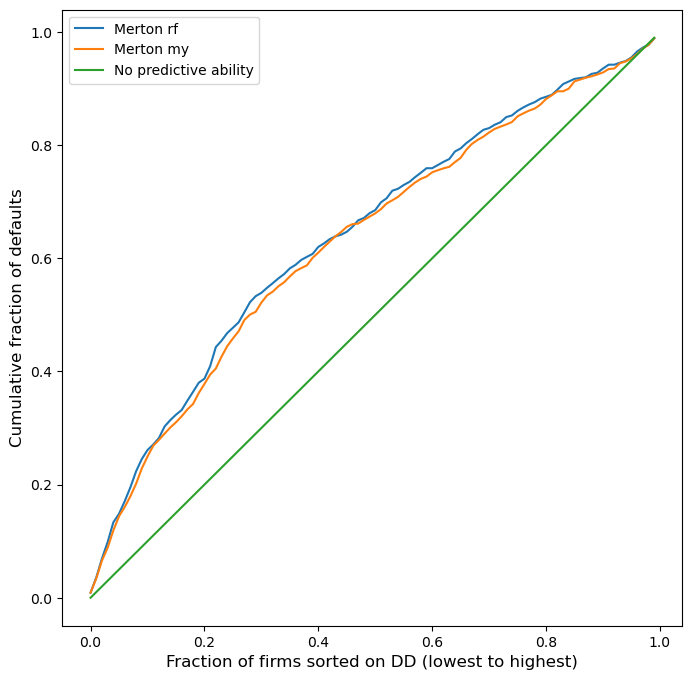

In [12]:

# I compute the power curve on the grid 0.01:0.01:1
pc_rf = np.zeros((end_year-start_year-2,100))
pc_my = np.zeros((end_year-start_year-2,100))
for j in range(0,len(power_curve_rf)-3):
    pc_rf[j,] = np.quantile(power_curve_rf[j,0:n_dd_year[j]],np.arange(0,1,0.01))
    pc_my[j,] = np.quantile(power_curve_my[j,0:n_dd_year[j]],np.arange(0,1,0.01))
# Average over years to get one power curve (per model)
average_pc_rf = np.mean(pc_rf,axis=0)
average_pc_my = np.mean(pc_my,axis=0)

fig,ax=plt.subplots(nrows=1,ncols=1)
ax.plot(np.arange(0,1,0.01),average_pc_rf,label='Merton rf')
ax.plot(np.arange(0,1,0.01),average_pc_my,label='Merton my')
ax.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),label='No predictive ability')
plt.xlabel('Fraction of firms sorted on DD (lowest to highest)',fontsize=12)
plt.ylabel('Cumulative fraction of defaults',fontsize=12)
plt.legend()
fig.set_size_inches(8, 8)


### Compute AC (2*dist btw pc and 45deg line)
Compute Accuracy ratio for each model

In [13]:
ac_rf = 2/100*np.nansum(np.abs(average_pc_rf-np.arange(0,1,0.01)))
ac_my = 2/100*np.nansum(np.abs(average_pc_my-np.arange(0,1,0.01)))
print(ac_my)
print(ac_rf)

0.2671025770272878
0.28709144424695654


Compute Accuracy ratio for each year for each model

In [14]:
ac_rf_yearly = 2/100*np.nansum(pc_rf-np.arange(0,1,0.01),axis=1)
ac_my_yearly = 2/100*np.nansum(pc_my-np.arange(0,1,0.01),axis=1)

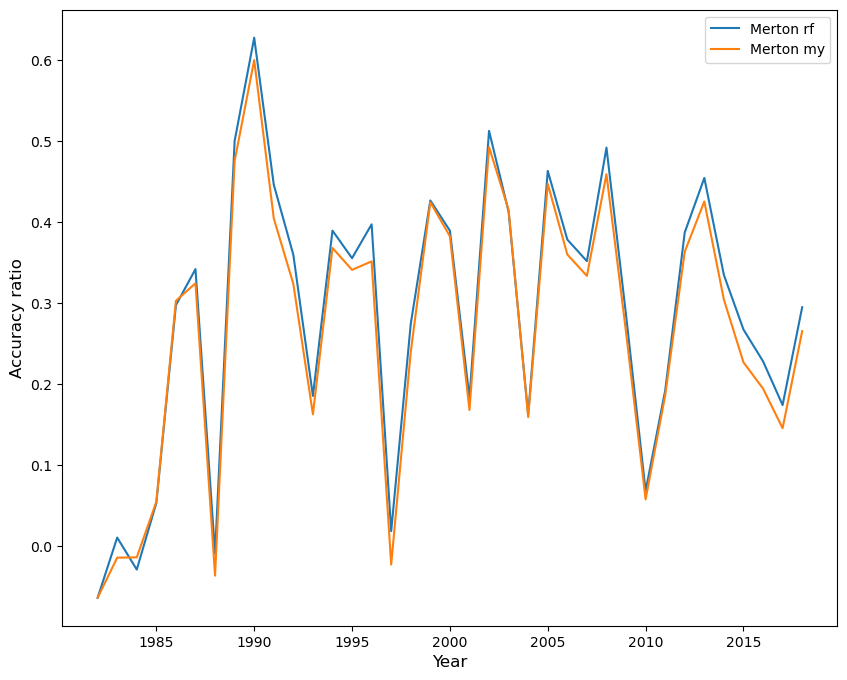

In [15]:
fig,ax=plt.subplots(nrows=1,ncols=1)
ax.plot(range(1982,2019),ac_rf_yearly,label='Merton rf')
ax.plot(range(1982,2019),ac_my_yearly,label='Merton my')
plt.xlabel('Year',fontsize=12)
plt.ylabel('Accuracy ratio',fontsize=12)
plt.legend()
fig.set_size_inches(10, 8)

Using the risk free seems a bit better but tiny difference. Confirms Afik et al. (2016) on larger sample. Accuracy ratio varies a lot between years. I don't really know why, maybe just noise, but potential Master's thesis topic 
## Is Merton getting the level of PD correct?

Text(0, 0.5, 'PD (%)')

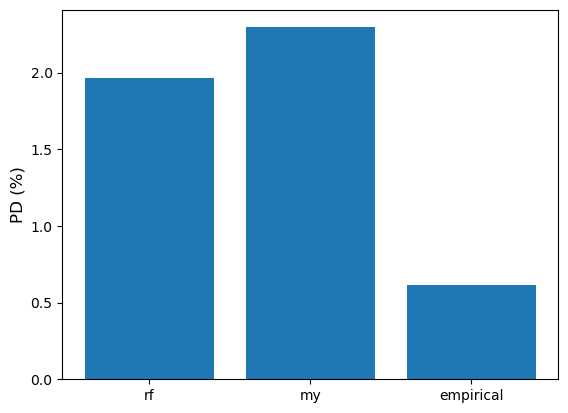

In [16]:
average_pd_riskfree = 100*np.nanmean(norm.cdf(-data.TB_merton_rf))
average_pd_my = 100*np.nanmean(norm.cdf(-data.TB_merton_my))
averge_empirical = 100*np.nanmean(data.defaulted)
fig,ax=plt.subplots(nrows=1,ncols=1)
ax.bar(['rf','my','empirical'],[average_pd_riskfree,average_pd_my,averge_empirical])
plt.ylabel('PD (%)',fontsize=12)
